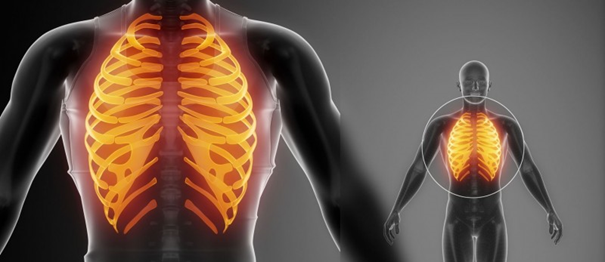

Bu projenin amacı, DICOM formatındaki postero-anterior (PA) CXR taramalarındaki yaygın torasik akciğer hastalıklarını sınıflandırmak ve kritik bulguları lokalize etmektir. Veri seti, tüm bulguların yokluğu da dahil olmak üzere 14 kritik radyografik bulgunun varlığı için deneyimli radyologlardan oluşan bir panel tarafından etiketlenen 18.000 kimliği belirsizleştirilmiş CXR taramasından oluşur. Görev, her test görüntüsündeki tüm bulgular için bir sınırlayıcı kutu ve sınıf tahmin etmeyi içerir. Belirtilen 14 sınıf aşağıdaki gibidir:

0- Aort genişlemesi (Aortic enlargement)

1- Atelektazi (Atelectasis)

2- Kireçlenme (Calcification)

3- Kardiyomegali (Cardiomegaly)

4- Konsolidasyon (Consolidation)

5- ILD 

6- Sızma (Infiltration)

7- Akciğer Opaklığı (Lung Opacity)

8- Nodül/Kitle (Nodule/Mass)

9- Diğer lezyon (Other lesion)

10- Plevral efüzyon (Pleural effusion)

11- Plevral kalınlaşma (Pleural thickening)

12- Pnömotoraks (Pneumothorax )

13- Pulmoner fibröz (Pulmonary fibrosis)



### Drive Mount Etme


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Veri kümelerini içe aktarma ve paketleri yükleme

In [ ]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
#!pip install --upgrade seaborn

# Train/Eğitim veri setini analiz etme 

In [ ]:
dim = 512
fold = 4
train_df = pd.read_csv('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/train.csv')
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040


In [ ]:
# Train ile ilgili detaylı bilgilerin yazdırılması

train_df['image_path'] = train_df['image_id'].apply(lambda x: os.path.join('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/train/', x + ('.png' if dim != 'original' else '.jpg')))
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
...,...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...


# Train.csv üstünde küçük Önişlemler


In [ ]:
# Sınıf sayısını alma

train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

In [ ]:
# x_min,x_max,x_mid,y_min,y_max,y_mid,height ve width değerlerini hesaplayarak veri kümesini önceden işleme

train_df['x_min'] = train_df['x_min'] / train_df['width']
train_df['y_min'] = train_df['y_min'] / train_df['height']
train_df['x_max'] = train_df['x_max'] / train_df['width']
train_df['y_max'] = train_df['y_max'] / train_df['height']

train_df['x_mid'] = (train_df['x_min'] + train_df['x_max']) / 2
train_df['y_mid'] = (train_df['y_min'] + train_df['y_max']) / 2

train_df['w'] = train_df['x_max'] - train_df['x_min']
train_df['h'] = train_df['y_max'] - train_df['y_min']

train_df['area'] = train_df['w'] * train_df['h']

train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.563462,0.686216,0.462500,0.195205,0.090283
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.623915,0.305903,0.150608,0.095833,0.014433
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.309843,0.128581,0.125984,0.024740,0.003117
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.773523,0.472407,0.368053,0.753033,0.277156
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.239875,0.721145,0.045950,0.039368,0.001809


In [ ]:
# Özellik sütunları için train_df'deki özellik/satır sayısı

features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
y = train_df['class_id']
X = train_df[features]
X.shape, y.shape

((36096, 9), (36096,))

In [ ]:
# Sınıf adlarının bir listesini alınması

classes = train_df['class_name'].unique()
classes.sort()
classes = list(map(str, classes))
classes


['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

# Eğitim setindeki dağılımları inceleme

In [ ]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 40, random_state=1, n_iter=5000)
data_X = X
data_y = y.loc[data_X.index]
embs = tsne.fit_transform(data_X)
# Kolaylık sağlamak için veri çerçevesi ekleme
plot_x = embs[:, 0]
plot_y = embs[:, 1]

CPU times: user 46min 49s, sys: 1min 44s, total: 48min 33s
Wall time: 29min 49s


<ipython-input-12-2dd4897d5d9c>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  legend = ax.legend(*scatter.legend_elements(), labels=classes, loc='best', title='Classes')


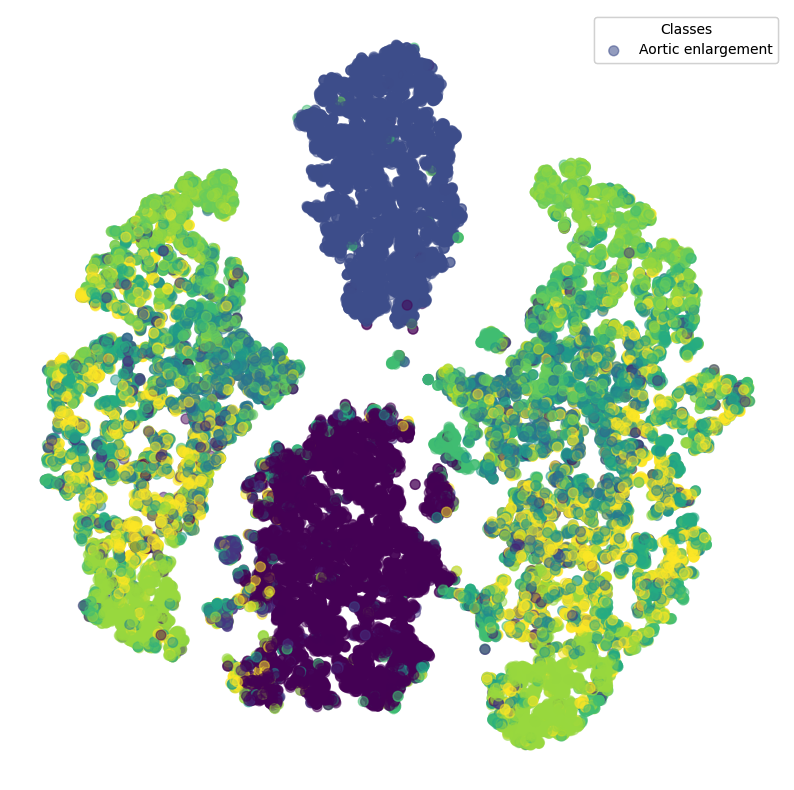

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

scatter = ax.scatter(plot_x, plot_y, marker='o', s=50, c=data_y.tolist(), alpha=0.5, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), labels=classes, loc='best', title='Classes')
ax.add_artist(legend)

plt.show()


<ipython-input-11-b89c036d12e5>:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  legend = ax.legend(*scatter.legend_elements(), labels=classes, loc='best', title='Classes')


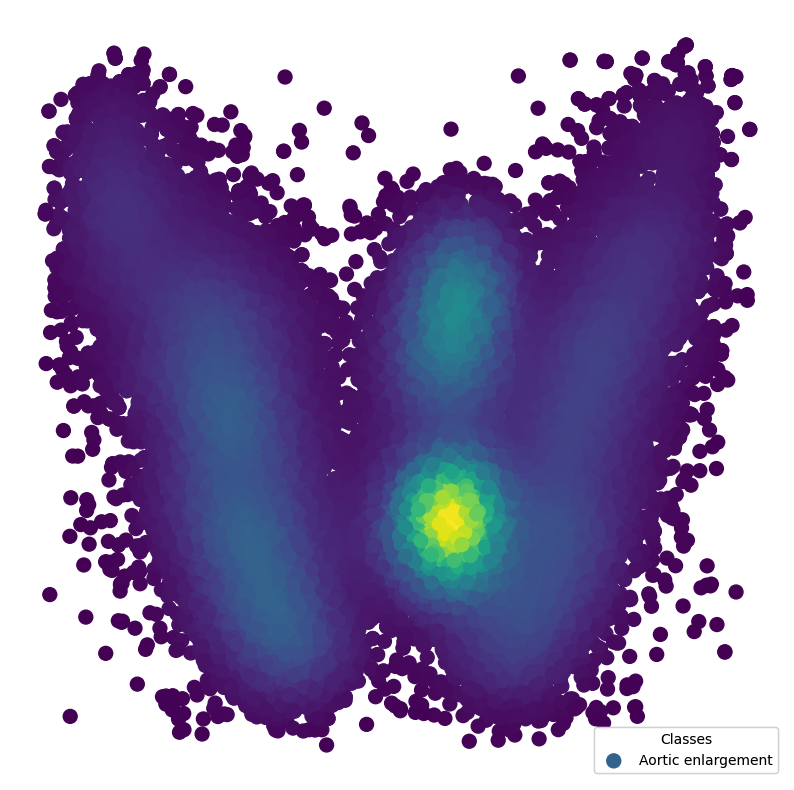

In [ ]:
from scipy.stats import gaussian_kde

x_val = X['x_mid'].values
y_val = X['y_mid'].values

# Calculate the point density
xy = np.vstack([x_val, y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
scatter = ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), labels=classes, loc='best', title='Classes')
ax.add_artist(legend)

plt.show()


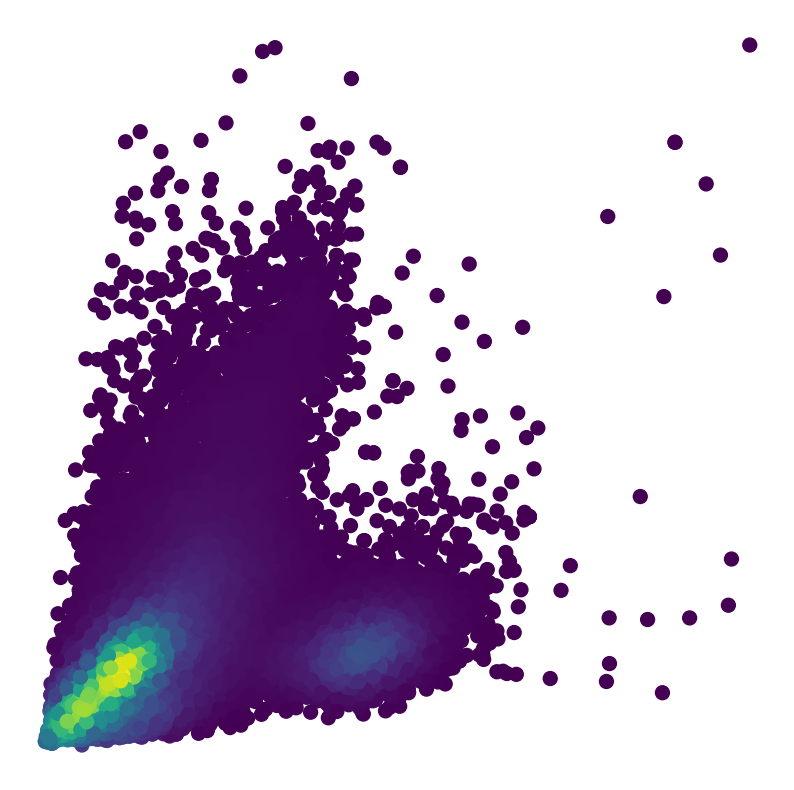

In [ ]:
x_val = train_df.w.values
y_val = train_df.h.values

xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
ax.set_xlabel('width')
ax.set_ylabel('height')
plt.show()


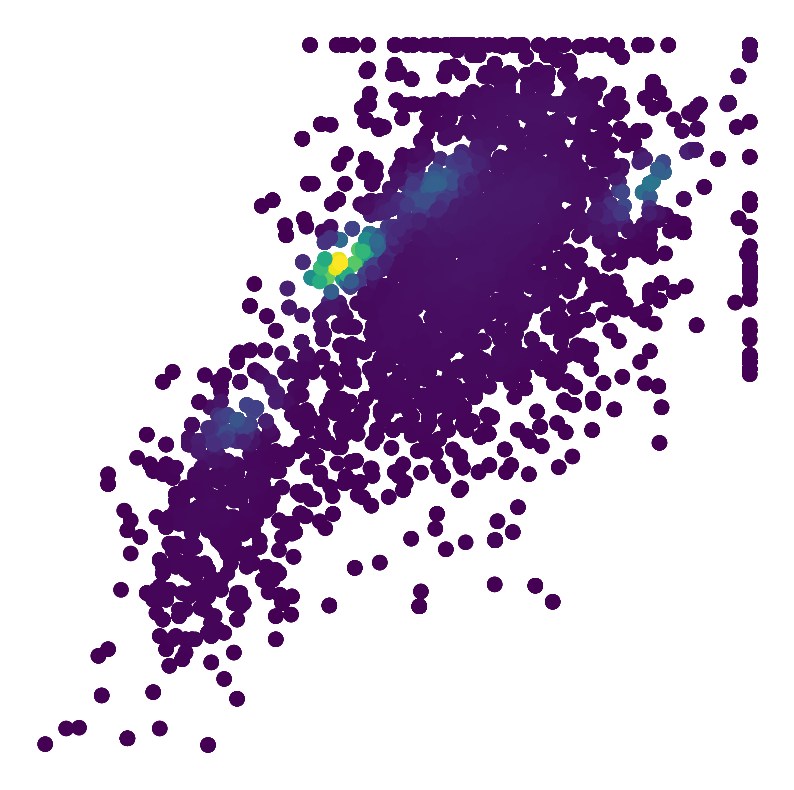

In [ ]:
x_val = train_df.width.values
y_val = train_df.height.values

xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
ax.set_xlabel('image_width')
ax.set_ylabel('image_height')
plt.show()


# Veri setini Bölme

In [ ]:
# Veri setini bölünmesi ve herhangi bir anormallik içermeyen tüm röntgenlerin bırakılması

n_splits = 5  # Oluşturulacak kat sayısı
group_kfold = GroupKFold(n_splits=n_splits)

train_df['fold'] = -1  # Tüm satırlar için 'katlama' sütununu -1 olarak başlatma  

# Verileri katlara ayırma ve katlama numarasını her satıra atama
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(train_df, groups=train_df['image_id'])):
    train_df.loc[val_idx, 'fold'] = fold

train_df.head()


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.563462,0.686216,0.462500,0.195205,0.090283,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.623915,0.305903,0.150608,0.095833,0.014433,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.309843,0.128581,0.125984,0.024740,0.003117,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.773523,0.472407,0.368053,0.753033,0.277156,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/trai...,0.239875,0.721145,0.045950,0.039368,0.001809,4


In [ ]:
# Fold sütununun geçerli fold sayısına eşit olduğu train_df DataFrame satırlarını filtreler ve bu satırlardaki benzersiz görüntü yollarını seçer. 
# Gerekli val veya train listesine ekler.

val_files = train_df[train_df['fold'] == fold]['image_path'].unique().tolist()
train_files = train_df[train_df['fold'] != fold]['image_path'].unique().tolist()

print(len(train_files)) 
print(len(val_files)) 


3515
879


# Dizin oluşturma ve dosyaları kopyalama 
(Bir sıkıntı olduğu taktirde orjinal veri setine zarar gelmemeli)

In [ ]:
os.makedirs('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/labels/train', exist_ok = True)
os.makedirs('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/labels/val', exist_ok = True)
os.makedirs('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/images/train', exist_ok = True)
os.makedirs('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/images/val', exist_ok = True)
label_dir = '/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/vinbigdata_yolo_labels_dataset/labels'
for file in tqdm(train_files): # dosyaların kopyalanmasının ilerlemesini görmek için tqdm kullandık
    shutil.copy(file, '/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/labels/val')

  0%|          | 0/3515 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

# **YOLOv5 Nedir?**

YOLOv5, popüler YOLO (Sadece Bir Kez Bakarsınız) nesne algılama algoritmaları ailesinin bir evrimi olan bir nesne algılama modelidir. Gerçek zamanlı video veya görüntülerdeki nesneleri algılamak ve sınıflandırmak için derin bir sinir ağı kullanır. YOLOv5, tek bir değerlendirmede doğrudan tam görüntülerden sınırlayıcı kutuları ve sınıf olasılıklarını tahmin eden bağlantı tabanlı bir kutu tahmin ediciye sahip tek bir sinir ağından oluşur. Yüksek kaliteli ek açıklamalara sahip büyük ölçekli veri kümeleri üzerinde eğitildiğinden, nesneleri yüksek doğrulukla algılama ve yeni verilere iyi genelleme yapma yeteneğine sahiptir. YOLOv5 ayrıca, YOLO'nun önceki sürümlerine kıyasla geliştirilmiş hız ve doğruluk sunarak, onu gerçek zamanlı nesne algılama görevleri için popüler bir seçim haline getirir.

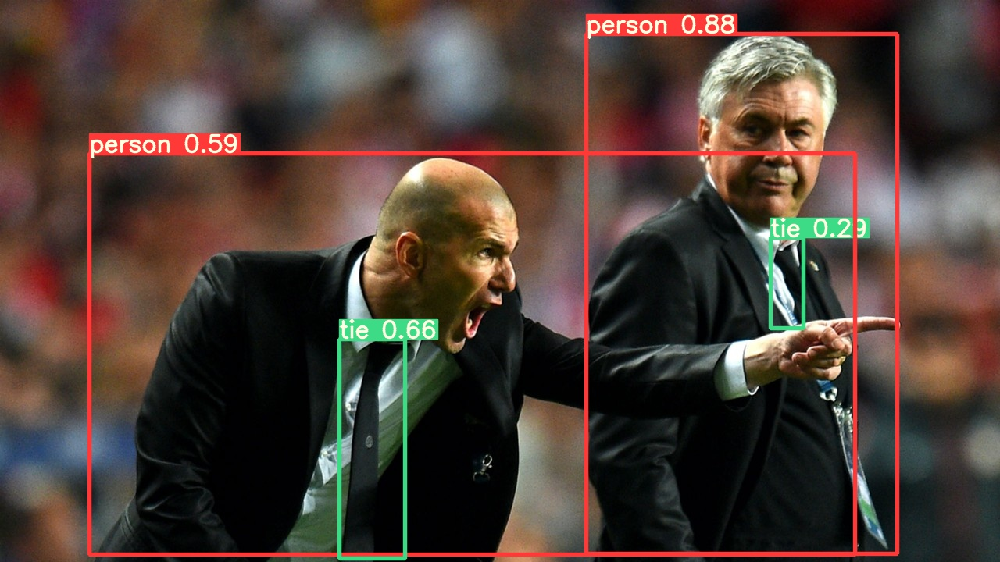

# YOLOv5'i Kurma

In [ ]:
# Yolo için ymal dosyasına ihtiyaç vardır. Ymal dosyasını burada oluşturuyoruz.
from os import listdir
from os.path import isfile, join
import yaml

cwd = '/gdrive/MyDrive/Lisans_Tezi_II'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/gdrive/MyDrive/Lisans_Tezi_II/vinbigdata/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml contents:')
print(f.read())


yaml contents:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /gdrive/MyDrive/Lisans_Tezi_II/train.txt
val: /gdrive/MyDrive/Lisans_Tezi_II/val.txt



In [ ]:
import torch
from IPython.display import Image, clear_output  # Görüntüleri görüntülemek ve çıktıları temizlemek için import edildi.

In [ ]:
# rmtree, yeni bir tane oluşturmadan önce kaggle dizininde bulunan herhangi bir yolov5 dizinini kaldırır.
# Kaggle çalışma dizininde yolov5 dizini yoksa bu işlevi çalıştırmak hata verir.
shutil.rmtree('/gdrive/MyDrive/Lisans_Tezi_II/yolov5')

In [ ]:
# YoloV5 kurulum ve CUDA kontrolü
shutil.copytree('/gdrive/MyDrive/Lisans_Tezi_II/yolov5-official-v31-dataset/yolov5', '/gdrive/MyDrive/Lisans_Tezi_II/yolov5')
os.chdir('/gdrive/MyDrive/Lisans_Tezi_II/yolov5')

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.0.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
pwd

'/gdrive/MyDrive/Lisans_Tezi_II/yolov5'

# Veri setini Eğitme ve Çapraz Doğrulama

In [ ]:
# Yolov5 kullanarak veri kümesini eğitme ve çapraz doğrulama
!WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 30 --data /gdrive/MyDrive/Lisans_Tezi_II/vinbigdata.yaml --weights yolov5x.pt --cache

100%|████████████████████████████████████████| 170M/170M [00:05<00:00, 35.7MB/s]

wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id 150paiyf.
wandb: Tracking run with wandb version 0.12.21
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
Scanning '/kaggle/working/vinbigdata/labels/train' for images and labels... 3515
Scanning '/kaggle/working/vinbigdata/labels/train.cache' for images and labels..
Caching images (4.3GB): 100%|██████████████| 3515/3515 [00:14<00:00, 247.36it/s]
Scanning '/kaggle/working/vinbigdata/labels/val' for images and labels... 879 fo
Scanning '/kaggle/working/vinbigdata/labels/val.cache' for images and labels... 
Caching images (1.1GB): 100%|████████████████| 879/879 [00:03<00:00, 231.72it/s]
Plotting labels... 

Analyzing anchors... anchors/target = 4.90, Best Possible Recall (BPR) = 0.9998
      0/29     14.5G   0.091

# Sonuçları görselleştirme

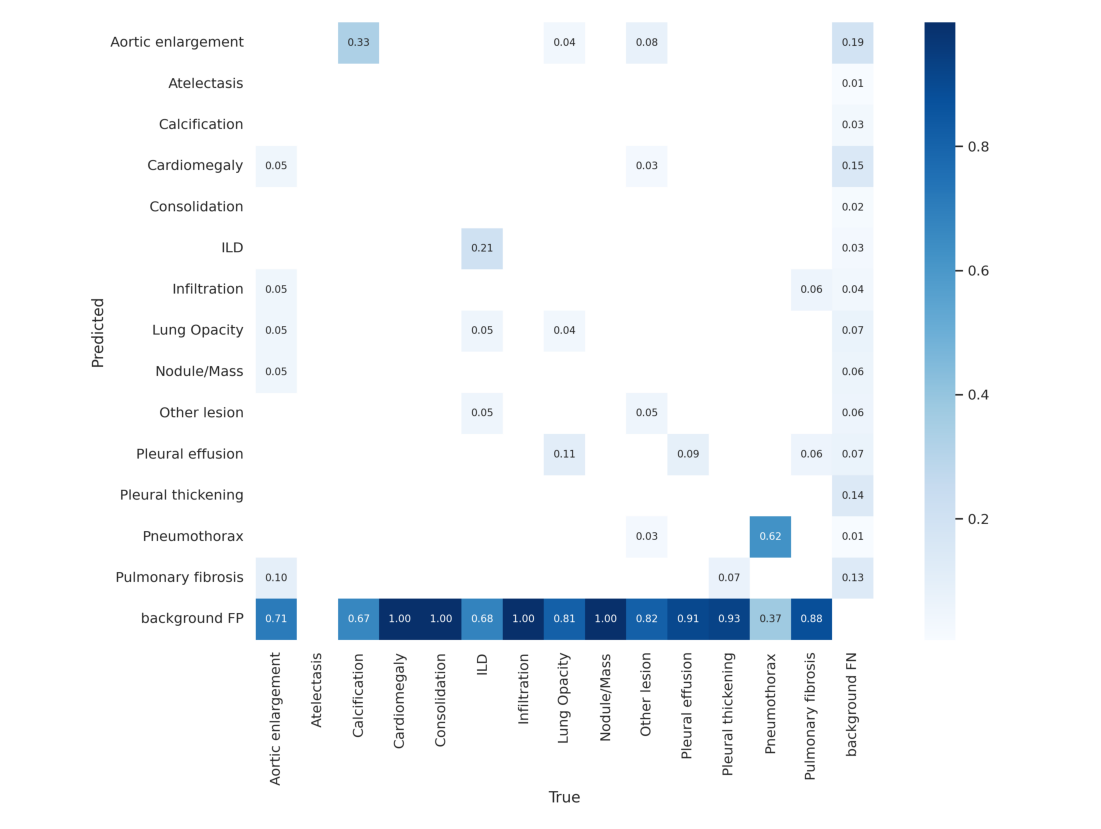

In [ ]:
# Veri kümelerini eğitirken bir karışıklık matrisi üretilir ve aşağıdaki yola kaydedilir. Yoldaki cm2yi yazdırma.
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# Model için Grafikler

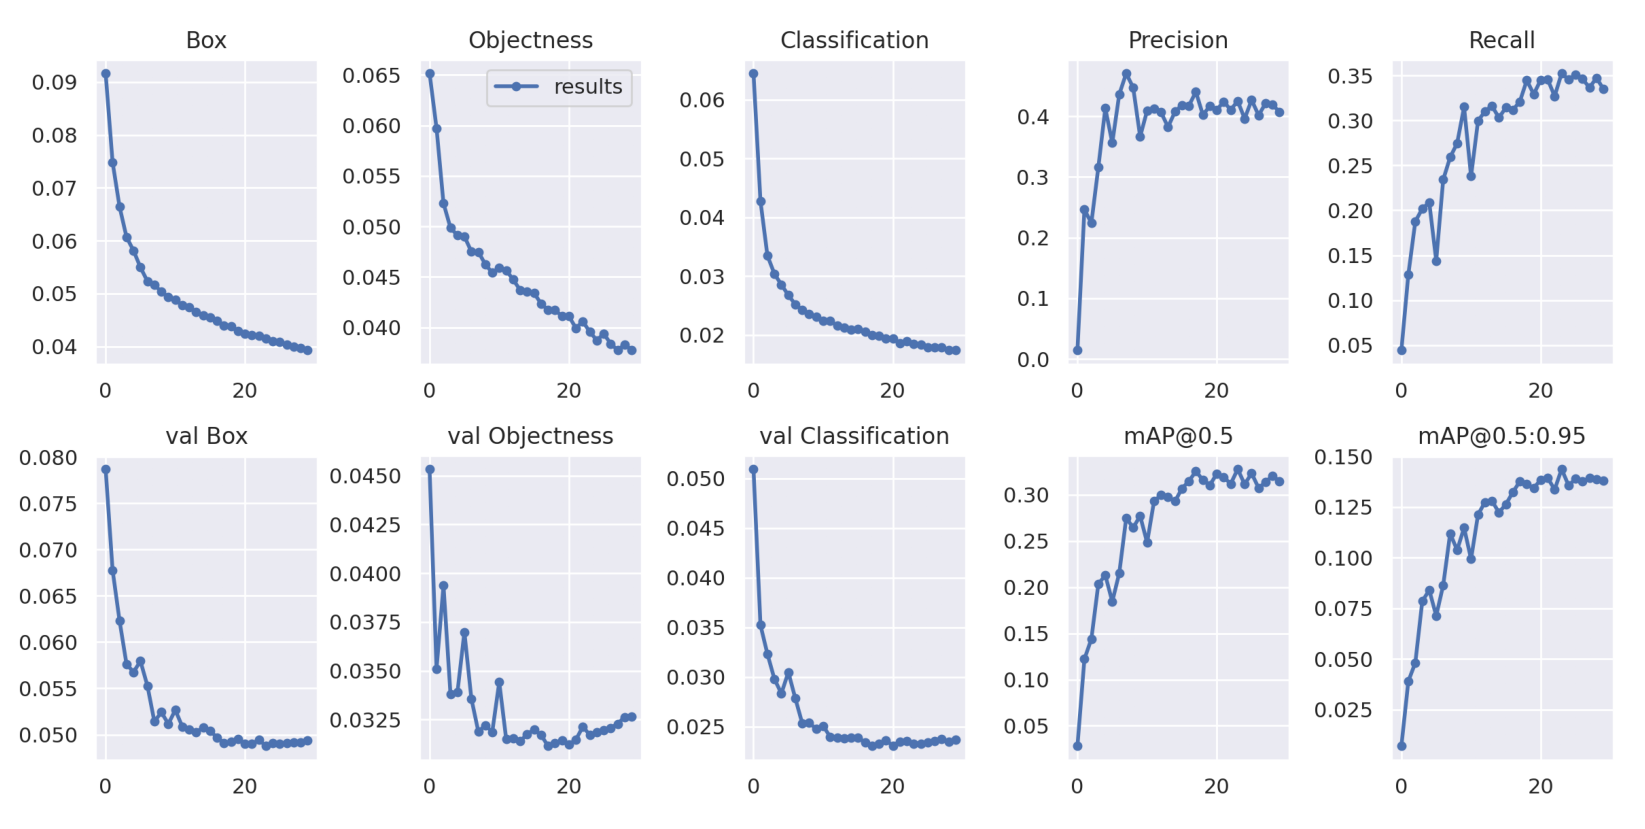

In [ ]:
# Verileri eğitmek, farklı eşikler için kayıp, kesinlik, geri çağırma ve mAP değerlerini hesaplar. Bunları grafik şeklinde aşağıda görmekteyiz.
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));